In [1]:
%matplotlib inline
import numpy as np
from skimage import io
import matplotlib
import matplotlib.pyplot as plt
import os
from glob import glob
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader

from EuroSAT_dataset import EuroSAT
from network import Net
from torchensemble import VotingClassifier


%load_ext autoreload
%autoreload 2


if not os.path.exists('./outputs'):
    os.mkdir('./outputs')

print('Imports OK')

Imports OK


In [11]:
# Global parameters

# If USE_CUDA is True, computations will be done using the GPU (may not work in all systems)
# This will make the calculations happen faster
USE_CUDA = True if torch.cuda.is_available() else False

DATASET_PATH = './EuroSAT_data'

BATCH_SIZE = 128 # Number of images that are used for calculating gradients at each step

NUM_EPOCHS = 50 # Number of times we will go through all the training images. Do not go over 25

LEARNING_RATE = 0.002 # Controls the step size
MOMENTUM = 0.95 # Momentum for the gradient descent
WEIGHT_DECAY = 5e-4 # Regularization factor to reduce overfitting

    

print('Parameters OK')

Parameters OK


In [12]:
# Create datasets and data loaders

train_dataset = EuroSAT(is_train=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = EuroSAT(is_train=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


print('Dataloaders OK')

Dataloaders OK


In [46]:
# Create network

model = Net()
if USE_CUDA:
    model.to(model._device)

ensemble = VotingClassifier(estimator=Net, n_estimators=10, cuda=USE_CUDA,)

print('Network OK')

Network OK


In [47]:
import torchsummary

torchsummary.summary(model, (3,64,64), BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 32, 64, 64]             896
       BatchNorm2d-2          [128, 32, 64, 64]              64
           Dropout-3          [128, 32, 64, 64]               0
              ReLU-4          [128, 32, 64, 64]               0
         MaxPool2d-5          [128, 32, 32, 32]               0
            Conv2d-6          [128, 64, 32, 32]          18,496
       BatchNorm2d-7          [128, 64, 32, 32]             128
              ReLU-8          [128, 64, 32, 32]               0
         MaxPool2d-9          [128, 64, 16, 16]               0
           Linear-10                 [128, 128]       2,097,280
             ReLU-11                 [128, 128]               0
          Dropout-12                 [128, 128]               0
           Linear-13                  [128, 64]           8,256
             ReLU-14                  [

In [48]:
# Define criterion, optimizer, and scheduler

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(recurse=True), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)#torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-4)

ensemble.set_criterion(criterion)
ensemble.set_optimizer('SGD',lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
ensemble.set_scheduler('CosineAnnealingLR', T_max=NUM_EPOCHS, eta_min=1e-4)

In [12]:
from torchensemble.utils.logging import set_logger

logger = set_logger("EuroSAT")

Log will be saved in '/home/serkan/CaseStudy/Codeway/codeway_coding_assignment/logs'.
Start logging into file /home/serkan/CaseStudy/Codeway/codeway_coding_assignment/logs/EuroSAT-2023_02_13_15_26.log...


In [13]:
import logging
logfilename = None
for handler in logger.handlers:
    if isinstance(handler, logging.FileHandler):
        logfilename = handler.baseFilename

In [14]:
import sys
with open(logfilename, 'w+') as sys.stdout:
    ensemble.fit(train_loader=train_loader, epochs=NUM_EPOCHS, log_interval=1, test_loader=test_loader, save_model=True, save_dir="./weights/")

2023-02-13 15:29:43,521 - INFO: Saving the model to `./weights/VotingClassifier_Net_10_ckpt.pth`
2023-02-13 15:29:43,658 - INFO: Epoch: 000 | Validation Acc: 74.056 % | Historical Best: 74.056 %
2023-02-13 15:32:44,201 - INFO: Epoch: 001 | Validation Acc: 69.556 % | Historical Best: 74.056 %
2023-02-13 15:35:44,674 - INFO: Saving the model to `./weights/VotingClassifier_Net_10_ckpt.pth`
2023-02-13 15:35:44,818 - INFO: Epoch: 002 | Validation Acc: 77.574 % | Historical Best: 77.574 %
2023-02-13 15:38:45,611 - INFO: Saving the model to `./weights/VotingClassifier_Net_10_ckpt.pth`
2023-02-13 15:38:45,750 - INFO: Epoch: 003 | Validation Acc: 79.259 % | Historical Best: 79.259 %
2023-02-13 15:41:47,020 - INFO: Saving the model to `./weights/VotingClassifier_Net_10_ckpt.pth`
2023-02-13 15:41:47,157 - INFO: Epoch: 004 | Validation Acc: 84.833 % | Historical Best: 84.833 %
2023-02-13 15:44:47,160 - INFO: Epoch: 005 | Validation Acc: 84.759 % | Historical Best: 84.833 %
2023-02-13 15:47:46,648 

In [30]:
from torchensemble.utils import io

model_ens = VotingClassifier(Net, n_estimators=10,cuda=True)

io.load(model_ens, "./weights/")

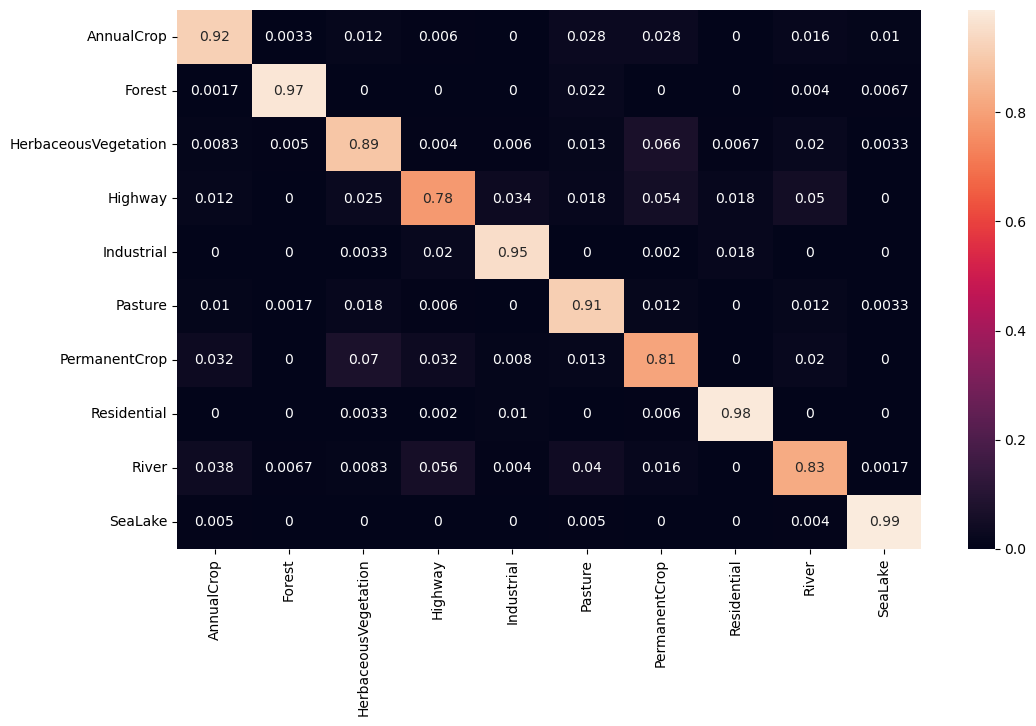

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from config import LABELS
import pandas as pd
import seaborn as sn

@torch.no_grad()
def plot_confusion_matrix(net_model: VotingClassifier, data_loader, criterion):
    
    preds = []
    gt = []
    loss = 0
    
    for sample in data_loader:
        
        inputs, labels = sample[0].to(model_ens.device), sample[1]
        
        # Already on cpu
        output = net_model.predict(inputs)
        
        loss += criterion(output, labels)
                
        preds.extend(torch.max(output, -1).indices.numpy())
        gt.extend(labels.numpy())
        
    cm = confusion_matrix(gt, preds)
    
    df_cm = pd.DataFrame(cm / np.sum(cm, axis=1), index = [i for i in LABELS],
                     columns = [i for i in LABELS])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    plt.savefig('./outputs/03-confusion_matrix.pdf')
    
    return loss.numpy() / len(gt) 
        
val_loss = plot_confusion_matrix(model_ens, test_loader, criterion)

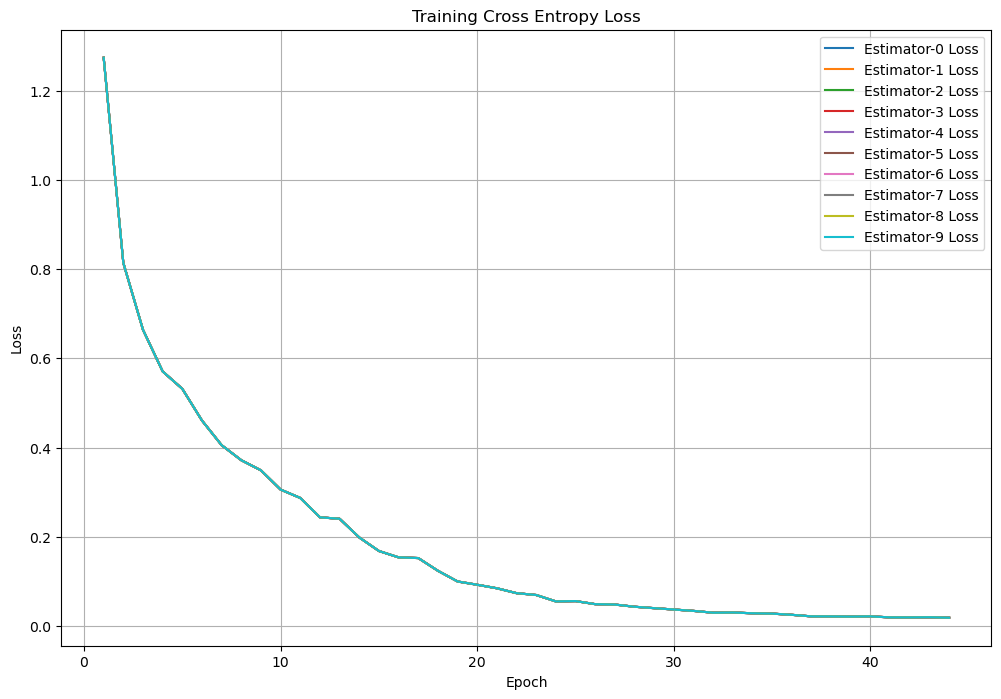

<Figure size 1200x800 with 0 Axes>

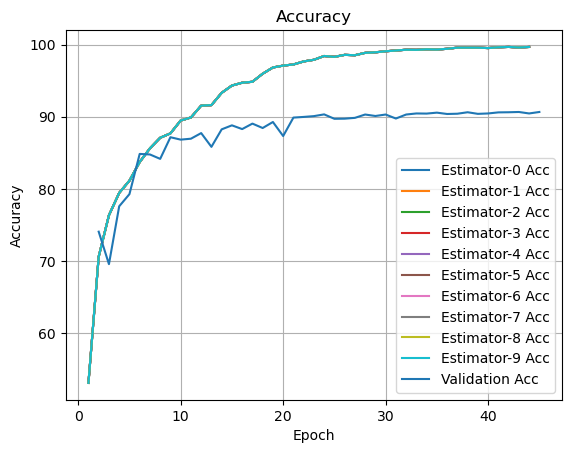

In [54]:
from plotter import plot_and_get_results

final_train_loss, final_train_acc, val_acc = plot_and_get_results("./logs/EuroSAT-2023_02_13_15_26.log")

In [55]:
print(f'Final train loss: {final_train_loss}')
print(f'Final test loss: {val_loss}')
print(f'Final train accuracy: {final_train_acc}')
print(f'Final test accuracy: {val_acc}')

Final train loss: 0.018757810650887576
Final test loss: 0.012530948497630931
Final train accuracy: 0.9966253698224852
Final test accuracy: 90.648


# Unused

In [ ]:
# Helper function to organize main loop
# This function is called for training and for testing at each epoch



def run_epoch(net: object, optimizer, dataloader, train, criterion, cuda=USE_CUDA):
    epoch_total_loss = 0
    epoch_total_samples = 0
    epoch_total_correct = 0

    for sample in tqdm(dataloader):
        img = sample[0]
        labels = sample[1]

        if cuda:
            img, labels = img.to(model._device), labels.to(model._device)
        
        
        if "n_estimators" in net.__dict__:
            outputs = net.predict()
        outputs = net(img)
        loss = criterion(outputs, labels)

        
        if train: #Be aware that this function should work both for training and testing
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                    
        with torch.no_grad():
            epoch_total_samples += labels.shape[0]
            epoch_total_correct += (labels == outputs.argmax(1)).cpu().float().sum()
            epoch_total_loss += loss.cpu().float()
               
    
    
    return epoch_total_loss / epoch_total_samples, epoch_total_correct / epoch_total_samples

In [ ]:
# Main loop

train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
epochs = []

for epoch in range(1, NUM_EPOCHS+1):
    print(f'\n\nRunning epoch {epoch} of {NUM_EPOCHS}...\n')
    epochs.append(epoch)

    #-------------------------Train-------------------------
    # Set network train/test mode to 'train' in the next line
    
    model.train(True)
    
    loss, accuracy = run_epoch(net=model, optimizer=optimizer, dataloader=train_loader, criterion=criterion, train=True, cuda=USE_CUDA)    
    train_loss.append(loss)
    train_accuracy.append(accuracy)
    
    # Update learning rate with scheduler in the next line
    scheduler.step()

    #-------------------------Test--------------------------
    # Set network train/test mode to 'test' in the next line
    
    model.train(False)
    
    #with torch.no_grad():
    loss, accuracy = run_epoch(net=model, optimizer=optimizer, dataloader=test_loader, criterion=criterion, train=False, cuda=USE_CUDA)    
    test_loss.append(loss)
    test_accuracy.append(accuracy)
    print(f'\nEpoch {epoch} validation results: Loss={loss} | Accuracy={accuracy}\n')
    
    


    
# Plot and save
plt.figure(figsize=(12, 8), num=1)
plt.clf()
plt.plot(epochs, train_loss, label='Train')
plt.plot(epochs, test_loss, label='Test')
plt.legend()
plt.grid()
plt.title('Cross entropy loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('outputs/01-loss.pdf')

plt.figure(figsize=(12, 8), num=2)
plt.clf()
plt.plot(epochs, train_accuracy, label='Train')
plt.plot(epochs, test_accuracy, label='Test')
plt.legend()
plt.grid()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig('outputs/02-accuracy.pdf')